##### Import Dependencies

In [1]:
import pandas as pd
import json
import os
import seaborn as sns
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers import LSTM, Input, Dropout, RepeatVector, TimeDistributed
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time

#### Logs Preprocessing Section

##### Import Access Logs

In [2]:
data_folder = "Data3"

In [3]:
df_access_logs = pd.read_csv(data_folder + "/logs/access.log",
                             skiprows=5,
                             sep=" ",
                             names=['ClientIP', 'Empty', 'Empty1', 'Time', 'TimeOffset', 'HTTPData', 'HTTPStatus', 'Total Time'],
                             usecols=[0, 1, 2, 3, 4, 5, 6, 7, 8],
                             engine='python')

new = df_access_logs.HTTPData.str.split(" ", n = 2, expand = True)
df_access_logs['URI'] = new[1]

df_access_logs = df_access_logs.drop(['ClientIP','Empty', 'Empty1', 'TimeOffset', 'HTTPData'], axis = 1)

##### Import Error Logs

In [4]:
df_error_logs = pd.read_csv(data_folder + "/logs/error.log",
                             sep="] ",
                             names=["Time", "LogType", "Client", 'Message'],
                             usecols=[0, 1, 2, 3],
                             engine='python')
df_error_logs = df_error_logs.drop(['LogType','Client'], axis = 1)

In [5]:
# Modifying the Time column and parsing as Datetime
df_access_logs['Time'] = df_access_logs['Time'].apply(lambda x: str(x)[1:])
df_error_logs['Time'] = df_error_logs['Time'].apply(lambda x: str(x)[1:])

# Localized time in the timezone converting to the UTC
df_access_logs['Time'] = pd.to_datetime(df_access_logs['Time'], format="%d/%b/%Y:%H:%M:%S").dt.tz_localize('Asia/Kolkata').dt.tz_convert('UTC')
df_error_logs['Time'] = pd.to_datetime(df_error_logs['Time'], format="%a %b %d %H:%M:%S %Y").dt.tz_localize('Asia/Kolkata').dt.tz_convert('UTC')

In [6]:
# Updaing the Elapesed total time column as numeric value and removing unncessary columns
df_access_logs['Total Time'] = pd.to_numeric(df_access_logs['Total Time'], errors='coerce')
df_access_logs['Total Time'] = df_access_logs['Total Time'].fillna(0)
df_access_logs = df_access_logs.drop(df_access_logs[df_access_logs['HTTPStatus'] == 408].index)

In [7]:
# Updating the index for the Access Logs DF
df_access_logs.index = pd.to_datetime(df_access_logs['Time'])
df_access_logs.index.rename('timeStamp', inplace=True)
df_access_logs = df_access_logs.drop(['Time'], axis = 1)

##### Visualizing the values of the Total Time column for visual inspection
##### Cheking the data for different distributions

<AxesSubplot:xlabel='timeStamp', ylabel='Total Time'>

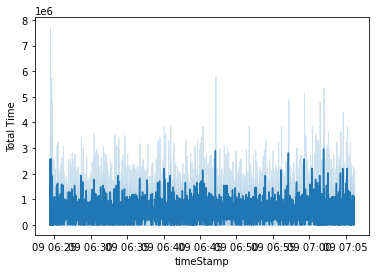

In [8]:
sns.lineplot(x=df_access_logs.index, y=df_access_logs['Total Time'])

##### Checking the failure Cases in the Data

In [10]:
df_access_logs.HTTPStatus.unique()

array([200, 304, 500], dtype=int64)

In [11]:
error_status_list = [500,501,502,503,400,401,402,404,408]
df_error = df_access_logs[df_access_logs.HTTPStatus.isin(error_status_list)].dropna(axis=0)

In [12]:
df_error.head(5)

,HTTPStatus,Total Time,URI
timeStamp,,,
2021-08-09 06:25:01+00:00,500,535.0,/cgi-bin/nav.pl?in=itinerary&page=menu
2021-08-09 06:28:09+00:00,500,535.0,/cgi-bin/nav.pl?in=home&page=menu


#### Metrics Preprocessing Section

##### Importing metrices collected during the test

In [13]:
df_metrices = pd.read_csv(data_folder + "/PerfmonData.csv",
                             skiprows = 1,
                             sep=",",
                             names=["timeStamp","counter","label","responseCode","responseMessage","threadName","dataType","success","failureMessage","bytes","sentBytes","grpThreads","allThreads","URL","Latency","IdleTime","Connect"],
                             usecols=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
                             engine='python')

df_metrices = df_metrices.drop(["responseCode","responseMessage","threadName","dataType","success","failureMessage","bytes","sentBytes","grpThreads","allThreads","URL","Latency","IdleTime","Connect"], axis = 1)

In [14]:
# Modifying the timestamp bases index and parsing to UTC
df_metrices.timeStamp = pd.to_datetime(df_metrices.timeStamp, unit='ms').dt.tz_localize('UTC')
df_metrices.index = df_metrices.timeStamp.apply(lambda x: x.replace(microsecond=0))
df_metrices = df_metrices.drop(['timeStamp'], axis = 1)

In [15]:
df_metrices.head(5)

,counter,label
timeStamp,,
2021-08-09 06:24:24+00:00,71006,localhost Memory
2021-08-09 06:24:24+00:00,18271,localhost CPU
2021-08-09 06:24:24+00:00,0,localhost Network I/O
2021-08-09 06:24:25+00:00,70976,localhost Memory
2021-08-09 06:24:25+00:00,14426,localhost CPU


In [16]:
# Segregating the three metrices from the data
df_cpu = df_metrices[df_metrices.label == 'localhost CPU']
df_network = df_metrices[df_metrices.label == 'localhost Network I/O']
df_memory = df_metrices[df_metrices.label == 'localhost Memory']

In [17]:
# Flatening the data into the row index based
df_cpu_mem = pd.merge(df_cpu, df_memory, left_index=True, right_index=True)
df_cpu_mem_net = pd.merge(df_cpu_mem, df_network, left_index=True, right_index=True)

In [18]:
# Cleaning renaming and checking the format
df_metrices = df_cpu_mem_net.drop(['label_x','label_y', 'label'], axis=1)
df_metrices.columns = ['CPU', 'Memory', 'IO']
df_metrices.head(5)

,CPU,Memory,IO
timeStamp,,,
2021-08-09 06:24:24+00:00,18271,71006,0
2021-08-09 06:24:25+00:00,14426,70976,1169000
2021-08-09 06:24:26+00:00,33532,71049,9583000
2021-08-09 06:24:27+00:00,22908,71034,1554000
2021-08-09 06:24:28+00:00,15067,71017,0


#### Test Results Preprocessing Section

##### Importing the File

In [19]:
df_results = pd.read_csv(data_folder + "/Metrices.csv",
                             skiprows = 1,
                             sep=",",
                             names=["timeStamp","elapedTime","label","responseCode","responseMessage","threadName","dataType","success","failureMessage","bytes","sentBytes","grpThreads","allThreads","URI","Latency","IdleTime","Connect"],
                             usecols=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
                             engine='python')
df_results = df_results.drop(['responseMessage', 'threadName', 'dataType', 'failureMessage', 'grpThreads', 'allThreads', 'Latency', 'IdleTime', 'Connect', 'bytes', 'sentBytes', 'label'], axis = 1)
df_results.head(5)

,timeStamp,elapedTime,responseCode,success,URI
0,1628490262987,586,200.0,True,NaN
1,1628490263179,88,200.0,True,http://localhost:2000/cgi-bin/login.pl
2,1628490263268,210,200.0,True,http://localhost:2000/cgi-bin/nav.pl?in=home&p...
3,1628490263479,215,200.0,True,http://localhost:2000/cgi-bin/login.pl?intro=true
4,1628490263695,57,200.0,True,http://localhost:2000/WebTours/images/flights.gif


In [20]:
# Preprocessing the columns based on the values
df_results = df_results.dropna(axis = 0)
df_results['URI'] = df_results['URI'].apply(lambda x: x[21:])

In [21]:
# Changing the datatype of the response code to integer
df_results['responseCode'] = df_results.responseCode.astype('int')

In [22]:
# CHanging the index of the dataframe to the timestamp based value and cleanup
df_results.timeStamp = pd.to_datetime(df_results.timeStamp, unit='ms')
df_results.index = df_results.timeStamp.apply(lambda x: x.replace(microsecond=0))
df_results = df_results.drop(['timeStamp'], axis = 1)
df_results.shape

(80604, 4)

#### Mearging the Three Dataframes

##### Logs and Results

In [23]:
# Creating the common key for the databases to be merged on
df_results["uristat"] = df_results["URI"] + '_'+ df_results["responseCode"].astype(str)
df_access_logs["uristat"] = df_access_logs["URI"] + '_'+ df_access_logs["HTTPStatus"].astype(str)

In [24]:
# Updating the index type and sorting dataframes based on indexes
df_results.index = df_results.index.astype('datetime64[ns, UTC]')
df_results_sorted = df_results.sort_index(axis = 0)
df_access_logs_sorted = df_access_logs.sort_index(axis = 0)

In [25]:
# Combining bases on the timestamp and generated key and cleaning up colums
combined = pd.merge_asof(df_results_sorted, df_access_logs_sorted, on='timeStamp', by='uristat')
combined.index = combined.timeStamp
combined = combined.drop(['URI_x','URI_y','responseCode', 'HTTPStatus', 'timeStamp'], axis = 1)
combined.head(5)

,elapedTime,success,uristat,Total Time
timeStamp,,,,
2021-08-09 06:24:23+00:00,88,True,/cgi-bin/login.pl_200,NaN
2021-08-09 06:24:23+00:00,210,True,/cgi-bin/nav.pl?in=home&page=menu_200,NaN
2021-08-09 06:24:23+00:00,215,True,/cgi-bin/login.pl?intro=true_200,NaN
2021-08-09 06:24:23+00:00,57,True,/WebTours/images/flights.gif_200,NaN
2021-08-09 06:24:23+00:00,7,True,/WebTours/images/itinerary.gif_200,NaN


##### Merging Combined with Metrices

In [171]:
df_final = combined.merge(df_metrices, on='timeStamp')
df_final.head(5)

,elapedTime,success,uristat,Total Time,CPU,Memory,IO
timeStamp,,,,,,,
2021-08-09 06:24:25+00:00,227,True,/cgi-bin/nav.pl?in=itinerary&page=menu_200,1482.0,14426,70976,1169000
2021-08-09 06:24:25+00:00,1928,True,/cgi-bin/itinerary.pl_200,7716521.0,14426,70976,1169000
2021-08-09 06:24:25+00:00,116,True,/cgi-bin/welcome.pl?page=itinerary_200,591.0,14426,70976,1169000
2021-08-09 06:24:27+00:00,46,True,/WebTours/images/cancelreservation.gif_200,831.0,22908,71034,1554000
2021-08-09 06:24:27+00:00,2,True,/WebTours/images/cancelallreservations.gif_200,742.0,22908,71034,1554000


#### Selecting Specific Transaction for the further Processing

In [172]:
#df_final = df_final[df_final.uristat == '/cgi-bin/welcome.pl?page=itinerary_200']
#df_final = df_final[df_final.uristat == '/cgi-bin/nav.pl?in=itinerary&page=menu_200']
df_final = df_final[df_final.uristat == '/cgi-bin/itinerary.pl_200']
df_final.head(5)

,elapedTime,success,uristat,Total Time,CPU,Memory,IO
timeStamp,,,,,,,
2021-08-09 06:24:25+00:00,1928,True,/cgi-bin/itinerary.pl_200,7716521.0,14426,70976,1169000
2021-08-09 06:24:29+00:00,1899,True,/cgi-bin/itinerary.pl_200,7716521.0,24761,71047,8596000
2021-08-09 06:24:30+00:00,1863,True,/cgi-bin/itinerary.pl_200,7716521.0,35354,71091,756000
2021-08-09 06:24:34+00:00,1989,True,/cgi-bin/itinerary.pl_200,7716521.0,31191,71054,0
2021-08-09 06:24:34+00:00,1799,True,/cgi-bin/itinerary.pl_200,7716521.0,31191,71054,0


In [173]:
df_final.shape

(4660, 7)

##### Data wrangling

In [174]:
df_final = df_final.drop(['success', 'Total Time', 'uristat'], axis = 1)
df_final.corr()

,elapedTime,CPU,Memory,IO
elapedTime,1.000000,0.134543,0.242898,0.118226
CPU,0.134543,1.000000,0.070433,0.012871
Memory,0.242898,0.070433,1.000000,0.173761
IO,0.118226,0.012871,0.173761,1.000000


In [175]:
df_final.index = df_final.index.tz_localize(None)
df_final.shape

(4660, 4)

In [176]:
# Normalisation
sc = MinMaxScaler()

df_final[["elapedTime", 'CPU', 'Memory', 'IO']] = sc.fit_transform(
    df_final[["elapedTime", 'CPU', 'Memory', 'IO']])

In [177]:
df_final = pd.DataFrame(df_final['elapedTime'])
df_final.shape

(4660, 1)

In [178]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

In [179]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

In [180]:
# Train Val Test Split
train_start = dt.datetime.strptime('2021-08-09 06:24:25', '%Y-%m-%d %H:%M:%S')
train_end = dt.datetime.strptime('2021-08-09 06:48:25', '%Y-%m-%d %H:%M:%S')
X_train = df_final.loc[train_start:train_end].values
Y_train = df_final.loc[train_start:train_end]['elapedTime'].values
X_train_df = df_final[(df_final.index >= train_start) & (df_final.index <=  train_end)]

val_start = dt.datetime.strptime('2021-08-09 06:48:26', '%Y-%m-%d %H:%M:%S')
val_end = dt.datetime.strptime('2021-08-09 06:57:25', '%Y-%m-%d %H:%M:%S')
X_val = df_final.loc[val_start:val_end].values
Y_val = df_final.loc[val_start:val_end]['elapedTime'].values
X_val_df = df_final[(df_final.index >= val_start) & (df_final.index <=  val_end)]

test_start = dt.datetime.strptime('2021-08-09 06:57:26', '%Y-%m-%d %H:%M:%S')
test_end = dt.datetime.strptime('2021-08-09 07:06:10', '%Y-%m-%d %H:%M:%S')
X_test = df_final.loc[test_start:test_end].values
Y_test = df_final.loc[test_start:test_end]['elapedTime'].values
X_test_df = df_final[(df_final.index >= test_start) & (df_final.index <=  test_end)]

print(X_train.shape,Y_train.shape, X_train_df.shape, X_val.shape,Y_val.shape,X_val_df.shape, X_test.shape,Y_test.shape,X_test_df.shape)

(2643, 1) (2643,) (2643, 1) (1099, 1) (1099,) (1099, 1) (918, 1) (918,) (918, 1)


In [181]:
seq_size = 50
x_train = unroll(X_train,seq_size)
x_val = unroll(X_val,seq_size)
x_test  = unroll(X_test,seq_size)

y_train = Y_train[-x_train.shape[0]:]
y_val = Y_val[-x_val.shape[0]:]
y_test  = Y_test[-x_test.shape[0]:]

In [182]:
print(x_train.shape,y_train.shape, x_val.shape,y_val.shape, x_test.shape, y_test.shape)

(2593, 50, 1) (2593,) (1049, 50, 1) (1049,) (868, 50, 1) (868,)


#### Model

In [130]:
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(x_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(x_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 50, 128)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50, 128)           131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 50, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

In [157]:
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data = (x_val, y_val),
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
81/81 [==============================] - 7s 92ms/step - loss: 0.0392 - val_loss: 0.0287
Epoch 2/100
81/81 [==============================] - 8s 96ms/step - loss: 0.0387 - val_loss: 0.0286
Epoch 3/100
81/81 [==============================] - 6s 76ms/step - loss: 0.0385 - val_loss: 0.0287
Epoch 4/100
81/81 [==============================] - 6s 75ms/step - loss: 0.0386 - val_loss: 0.0287
Epoch 5/100
81/81 [==============================] - 6s 76ms/step - loss: 0.0388 - val_loss: 0.0288


In [132]:
model.reset_states()

In [133]:
model,train_error,val_error = model, history.history['loss'], history.history['val_loss']

In [134]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

In [135]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

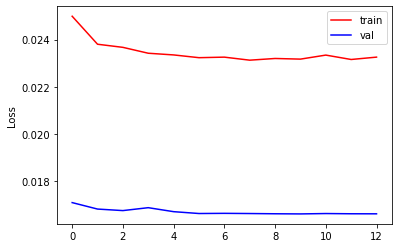

In [136]:
plot_error(train_error,val_error)

Reconstruction error threshold: 0.2678517222639247


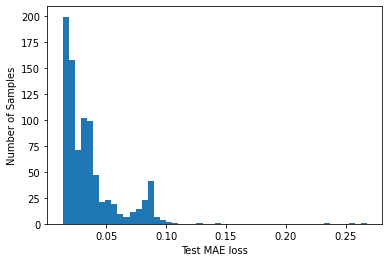

In [137]:
test_predict = model.predict(x_test)
test_mae_loss = np.mean(np.abs(test_predict - x_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(test_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

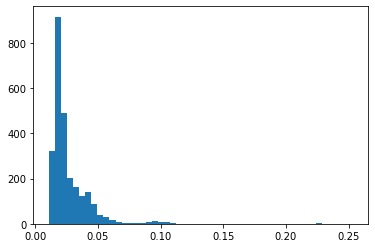

In [138]:
train_predict = model.predict(x_train)
train_mea_loss = np.mean(np.abs(train_predict - x_train), axis=1)
plt.hist(train_mea_loss, bins=50)
max_train_mae = 0.26

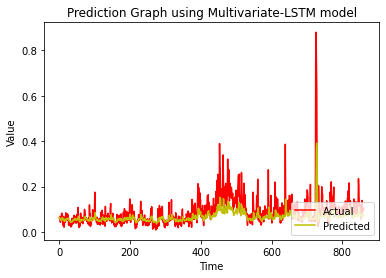

In [139]:
test_predicted_avg = np.mean(np.abs(y_hat), axis=1)
plot_data(y_test,test_predicted_avg)

In [142]:
error_df = pd.DataFrame(X_test_df[seq_size:])
error_df['test_mae'] = test_mae_loss
error_df['max_train_mae'] = max_train_mae
error_df['anomaly'] = error_df['test_mae'] > error_df['max_train_mae']
error_df['elapedTime'] = X_test_df[seq_size:]['elapedTime']

<AxesSubplot:xlabel='timeStamp', ylabel='test_mae'>

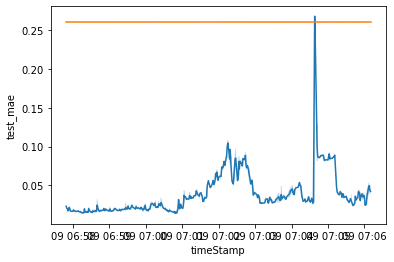

In [143]:
sns.lineplot(x=error_df.index, y=error_df['test_mae'])
sns.lineplot(x=error_df.index, y=error_df['max_train_mae'])

In [144]:
error_df[error_df.anomaly == True]

,elapedTime,test_mae,max_train_mae,anomaly
timeStamp,,,,
2021-08-09 07:04:38,0.630744,0.267852,0.26,True


#### Second Transaction

In [158]:
model.reset_states()

In [159]:
model,train_error,val_error = model, history.history['loss'], history.history['val_loss']

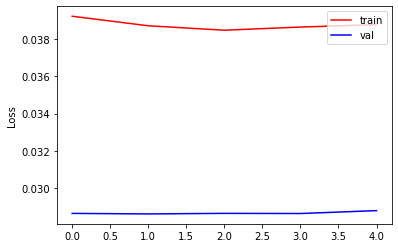

In [160]:
plot_error(train_error,val_error)

Reconstruction error threshold: 0.1419731656437606


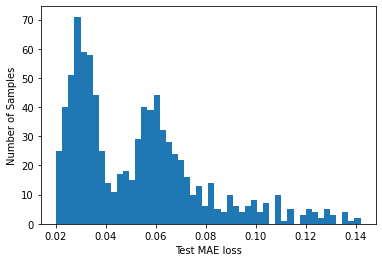

In [162]:
test_predict = model.predict(x_test)
test_mae_loss = np.mean(np.abs(test_predict - x_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(test_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

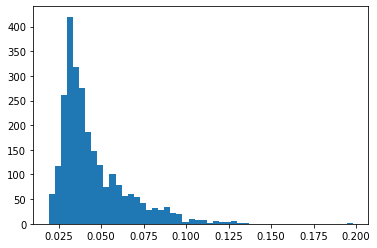

In [163]:
train_predict = model.predict(x_train)
train_mea_loss = np.mean(np.abs(train_predict - x_train), axis=1)
plt.hist(train_mea_loss, bins=50)
max_train_mae = 0.14

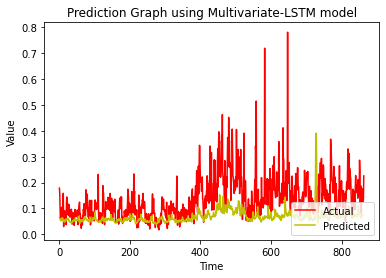

In [164]:
test_predicted_avg = np.mean(np.abs(y_hat), axis=1)
plot_data(y_test,test_predicted_avg)

In [165]:
error_df = pd.DataFrame(X_test_df[seq_size:])
error_df['test_mae'] = test_mae_loss
error_df['max_train_mae'] = max_train_mae
error_df['anomaly'] = error_df['test_mae'] > error_df['max_train_mae']
error_df['elapedTime'] = X_test_df[seq_size:]['elapedTime']

<AxesSubplot:xlabel='timeStamp', ylabel='test_mae'>

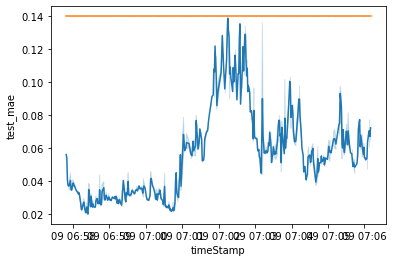

In [166]:
sns.lineplot(x=error_df.index, y=error_df['test_mae'])
sns.lineplot(x=error_df.index, y=error_df['max_train_mae'])

In [167]:
error_df[error_df.anomaly == True]

,elapedTime,test_mae,max_train_mae,anomaly
timeStamp,,,,
2021-08-09 07:02:34,0.167484,0.141973,0.14,True


#### Third Transaction

In [183]:
model.reset_states()

In [159]:
model,train_error,val_error = model, history.history['loss'], history.history['val_loss']

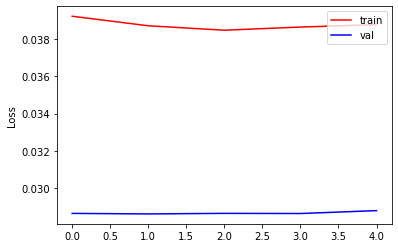

In [160]:
plot_error(train_error,val_error)

Reconstruction error threshold: 0.3763939668174192


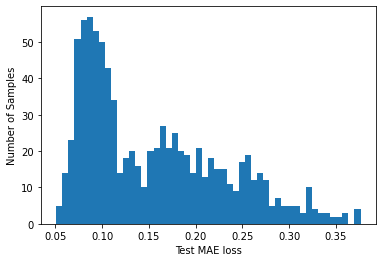

In [184]:
test_predict = model.predict(x_test)
test_mae_loss = np.mean(np.abs(test_predict - x_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(test_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

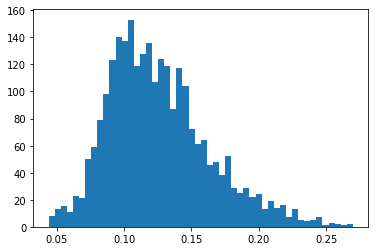

In [204]:
train_predict = model.predict(x_train)
train_mea_loss = np.mean(np.abs(train_predict - x_train), axis=1)
plt.hist(train_mea_loss, bins=50)
max_train_mae = 0.30

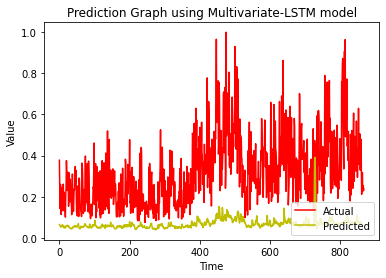

In [205]:
test_predicted_avg = np.mean(np.abs(y_hat), axis=1)
plot_data(y_test,test_predicted_avg)

In [206]:
error_df = pd.DataFrame(X_test_df[seq_size:])
error_df['test_mae'] = test_mae_loss
error_df['max_train_mae'] = max_train_mae
error_df['anomaly'] = error_df['test_mae'] > error_df['max_train_mae']
error_df['elapedTime'] = X_test_df[seq_size:]['elapedTime']

<AxesSubplot:xlabel='timeStamp', ylabel='test_mae'>

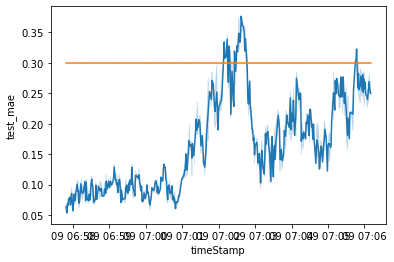

In [207]:
sns.lineplot(x=error_df.index, y=error_df['test_mae'])
sns.lineplot(x=error_df.index, y=error_df['max_train_mae'])

In [214]:
anomalies = error_df.loc[error_df.anomaly == True]
anomalies

,elapedTime,test_mae,max_train_mae,anomaly
timeStamp,,,,
2021-08-09 07:01:57,1.000000,0.302799,0.3,True
2021-08-09 07:02:08,0.341490,0.303339,0.3,True
2021-08-09 07:02:09,0.506335,0.334244,0.3,True
2021-08-09 07:02:10,0.465069,0.307429,0.3,True
2021-08-09 07:02:12,0.308912,0.309508,0.3,True
2021-08-09 07:02:14,0.415768,0.344515,0.3,True
2021-08-09 07:02:14,0.497937,0.332923,0.3,True
2021-08-09 07:02:15,0.670238,0.311119,0.3,True
2021-08-09 07:02:17,0.503946,0.327411,0.3,True
